In [1]:
import numpy as np
import keras.backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
hidden_dim = 2
batch_size = 64

In [4]:
def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

In [5]:
input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)

In [6]:
z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

In [7]:
def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

In [8]:
h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])
input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(d)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

In [13]:
reconstruction_loss = MeanSquaredError()(input_img, vae_output)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [9]:
encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")

In [10]:
kl_weight = 0.0001

def vae_loss(x, y):
    x = K.reshape(x, shape=(-1, 28*28))
    y = K.reshape(y, shape=(-1, 28*28))
    loss = K.mean(K.square(x-y))
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_weight * kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [11]:
history = vae.fit(x_train, x_train, epochs=20, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
938/938 [==============================] - 23s 21ms/step - loss: 0.0830 - val_loss: 0.0529
Epoch 2/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0544 - val_loss: 0.0497
Epoch 3/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0520 - val_loss: 0.0479
Epoch 4/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0503 - val_loss: 0.0459
Epoch 5/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0491 - val_loss: 0.0445
Epoch 6/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0482 - val_loss: 0.0438
Epoch 7/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0477 - val_loss: 0.0437
Epoch 8/20
938/938 [==============================] - 14s 15ms/step - loss: 0.0471 - val_loss: 0.0433
Epoch 9/20
938/938 [==============================] - 13s 14ms/step - loss: 0.0469 - val_loss: 0.0426
Epoch 10/20
938/938 [==============================] - 13s 14ms/step - loss: 0.046

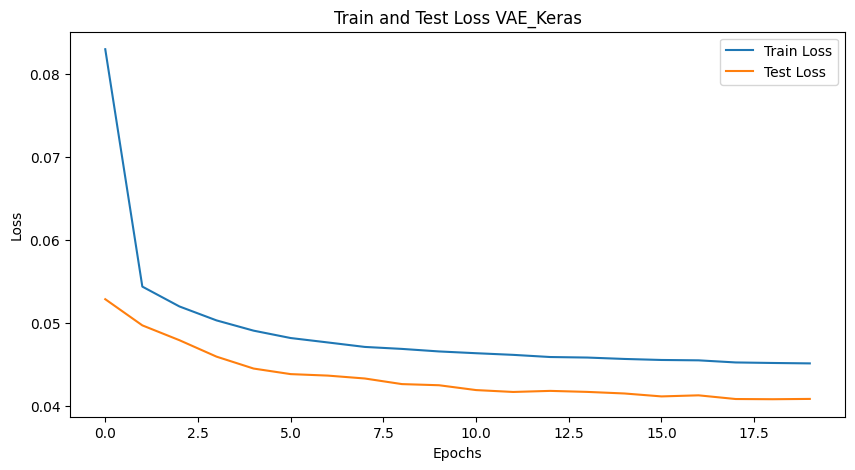

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss VAE_Keras')
plt.legend()
plt.show()

1/1 [==============================] - 0s 421ms/step


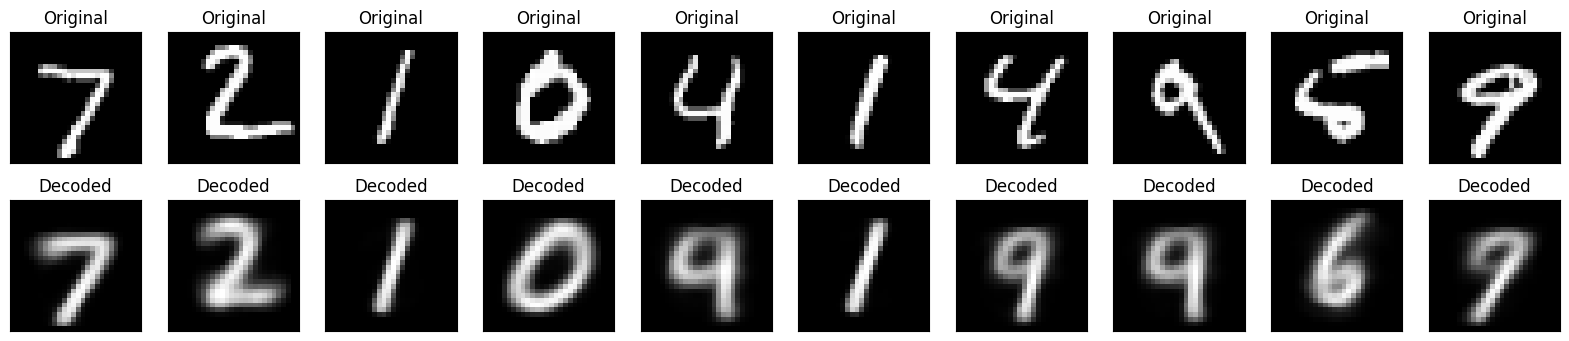

In [13]:
n = 10
imgs = x_test[:n]
decoded_imgs = vae.predict(x_test[:n], batch_size=n)

plt.figure(figsize=(2*n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')

    ax2 = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title('Decoded')

plt.show()

In [ ]:
#Висновок: швидкість тренування висока, точність декодування нижча, ніж у звичайного автокодувальника